In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import jit

In [3]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [4]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [6]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [7]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [8]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [9]:
numpeaks_id = np.load('../features/numpeaks_id.npy')
numpospeaks_id = np.load('../features/numpospeaks_id.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id .npy')

maxamp_id = np.load('../features/maxamp_id.npy')
minamp_id = np.load('../features/minamp_id.npy')
meanamp_id = np.load('../features/meanamp_id.npy')

meanamppos_id = np.load('../features/meanamppos_id.npy')
meanampneg_id = np.load('../features/meanampneg_id.npy')


In [10]:
stdamp_id = np.load('../features/stdamp_id.npy')
stdamppos_id = np.load('../features/stdamppos_id.npy')
stdampneg_id = np.load('../features/stdampneg_id.npy')

numpeaksq2_id = np.load('../features/numpeaksq2_id.npy')
numpeaksq3_id = np.load('../features/numpeaksq3_id.npy')
numpeaksq4_id = np.load('../features/numpeaksq4_id.npy')

numpospeaksq2_id = np.load('../features/numpospeaksq2_id.npy')
numpospeaksq3_id = np.load('../features/numpospeaksq3_id.npy')
numpospeaksq4_id = np.load('../features/numpospeaksq4_id.npy')

numnegpeaksq2_id = np.load('../features/numnegpeaksq2_id.npy')
numnegpeaksq3_id = np.load('../features/numnegpeaksq3_id.npy')
numnegpeaksq4_id = np.load('../features/numnegpeaksq4_id.npy')

coefampq2q3_id = np.load('../features/coefampq2q3_id.npy')
coefampq2q4_id = np.load('../features/coefampq2q4_id.npy')

stdampq2_id = np.load('../features/stdampq2_id.npy')
stdampq3_id = np.load('../features/stdampq3_id.npy')
stdampq4_id = np.load('../features/stdampq4_id.npy')

stdposampq2_id = np.load('../features/stdposampq2_id.npy')
stdposampq3_id = np.load('../features/stdposampq3_id.npy')
stdposampq4_id = np.load('../features/stdposampq4_id.npy')

stdnegampq2_id = np.load('../features/stdnegampq2_id.npy')
stdnegampq3_id = np.load('../features/stdnegampq3_id.npy')
stdnegampq4_id = np.load('../features/stdnegampq4_id.npy')

meanampq2_id = np.load('../features/meanampq2_id.npy')
meanampq3_id = np.load('../features/meanampq3_id.npy')
meanampq4_id = np.load('../features/meanampq4_id.npy')

meanposampq2_id = np.load('../features/meanposampq2_id.npy')
meanposampq3_id = np.load('../features/meanposampq3_id.npy')
meanposampq4_id = np.load('../features/meanposampq4_id.npy')

meannegampq2_id = np.load('../features/meannegampq2_id.npy')
meannegampq3_id = np.load('../features/meannegampq3_id.npy')
meannegampq4_id = np.load('../features/meannegampq4_id.npy')

In [11]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id, 'NumPosPeaks_ID':numpospeaks_id, 'NumNegPeaks_ID':numnegpeaks_id,
                        'MaxAmp_ID':maxamp_id, 'MinAmp_ID':minamp_id, 'MeanAmp_ID':meanamp_id,
                        'MeanAmpPos_ID':meanamppos_id, 'MeanAmpNeg_ID':meanampneg_id, 'StdAmp_ID':stdamp_id, 'StdAmpPos_ID':stdamppos_id,
                        'StdAmpNeg_ID':stdampneg_id, 
                        #'NumPeaksQ2_ID':numpeaksq2_id, 'NumPeaksQ3_ID':numpeaksq3_id,
                        #'NumPeaksQ4_ID':numpeaksq4_id, 'NumPosPeaksQ2_ID':numpospeaksq2_id, 'NumPosPeaksQ3_ID':numpospeaksq3_id,
                        #'NumPosPeaksQ4_ID':numpospeaksq4_id, 'NumNegPeaksQ2_ID':numnegpeaksq2_id, 'NumNegPeaksQ3_ID':numnegpeaksq3_id,
                        #'NumNegPeaksQ4_ID':numnegpeaksq4_id, 'CoefAmpQ2Q3_ID':coefampq2q3_id, 'CoefAmpQ2Q4_ID':coefampq2q4_id, 
                        #'StdAmpQ2_ID':stdampq2_id, 'StdAmpQ3_ID':stdampq3_id, 'StdAmpQ4_ID':stdampq4_id,
                        #'StdPosAmpQ2_ID':stdposampq2_id, 'StdPosAmpQ3_ID':stdposampq3_id, 'StdPosAmpQ4_ID':stdposampq4_id,
                        #'StdNegAmpQ2_ID':stdnegampq2_id, 'StdNegAmpQ3_ID':stdnegampq3_id, 'StdNegAmpQ4_ID':stdnegampq4_id,
                        #'MeanAmpQ2_ID':meanampq2_id, 'MeanAmpQ3_ID':meanampq3_id, 'MeanAmpQ4_ID':meanampq4_id,
                        #'MeanPosAmpQ2_ID':meanposampq2_id, 'MeanPosAmpQ3_ID':meanposampq3_id, 'MeanPosAmpQ4_ID':meanposampq4_id,
                        #'MeanNegAmpQ2_ID':meannegampq2_id, 'MeanNegAmpQ3_ID':meannegampq3_id, 'MeanNegAmpQ4_ID':meannegampq4_id,
                        })

In [12]:
train = pd.concat([meta_train, train_features], axis=1)

In [13]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,NumPeaks_ID,NumPosPeaks_ID,NumNegPeaks_ID,MaxAmp_ID,MinAmp_ID,MeanAmp_ID,MeanAmpPos_ID,MeanAmpNeg_ID,StdAmp_ID,StdAmpPos_ID,StdAmpNeg_ID
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788,0.307583,4.981484,8.096532
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788,0.307583,4.981484,8.096532


In [14]:
signal_id = train['signal_id'].values
del train['signal_id']

In [15]:
target = train['target'].values
del train['target']

In [16]:
from sklearn.metrics import matthews_corrcoef

In [17]:
kf = KFold(n_splits=4, random_state=123, shuffle=False)

In [18]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=False)

[1]	valid_0's MCC: 0.612443
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.640714
[3]	valid_0's MCC: 0.627549
[4]	valid_0's MCC: 0.61564
[5]	valid_0's MCC: 0.620188
[6]	valid_0's MCC: 0.616446
[7]	valid_0's MCC: 0.620986
[8]	valid_0's MCC: 0.624768
[9]	valid_0's MCC: 0.616897
[10]	valid_0's MCC: 0.61633
[11]	valid_0's MCC: 0.615123
[12]	valid_0's MCC: 0.622547
[13]	valid_0's MCC: 0.628109
[14]	valid_0's MCC: 0.627441
[15]	valid_0's MCC: 0.631241
[16]	valid_0's MCC: 0.635168
[17]	valid_0's MCC: 0.640287
[18]	valid_0's MCC: 0.632712
[19]	valid_0's MCC: 0.627542
[20]	valid_0's MCC: 0.634908
[21]	valid_0's MCC: 0.634908
[22]	valid_0's MCC: 0.638917
[23]	valid_0's MCC: 0.638917
[24]	valid_0's MCC: 0.640313
[25]	valid_0's MCC: 0.642851
[26]	valid_0's MCC: 0.644625
[27]	valid_0's MCC: 0.641129
[28]	valid_0's MCC: 0.641399
[29]	valid_0's MCC: 0.64782
[30]	valid_0's MCC: 0.645273
[31]	valid_0's MCC: 0.647353
[32]	valid_0's MCC: 0.655178
[33]	valid_0's MCC: 0.

[52]	valid_0's MCC: 0.657374
[53]	valid_0's MCC: 0.654638
[54]	valid_0's MCC: 0.661343
[55]	valid_0's MCC: 0.654661
[56]	valid_0's MCC: 0.652017
[57]	valid_0's MCC: 0.662829
[58]	valid_0's MCC: 0.667992
[59]	valid_0's MCC: 0.666024
[60]	valid_0's MCC: 0.667517
[61]	valid_0's MCC: 0.663551
[62]	valid_0's MCC: 0.667517
[63]	valid_0's MCC: 0.661112
[64]	valid_0's MCC: 0.661343
[65]	valid_0's MCC: 0.669448
[66]	valid_0's MCC: 0.674585
Early stopping, best iteration is:
[36]	valid_0's MCC: 0.682396
0.6823955147335914 0.6823955147335914


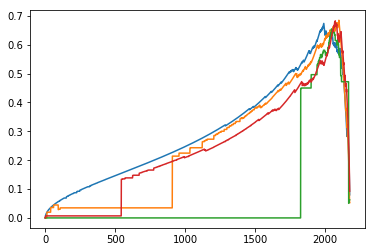

In [19]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in kf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [20]:
proba

[0.14416656302125944,
 0.709452678548079,
 0.11985985691068489,
 0.26983888233217046]

In [21]:
val_mcc

[0.6735603777968848, 0.6845478920455796, 0.654565319494933, 0.6823955147335914]

In [22]:
np.mean(val_mcc)

0.6737672760177472

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(proba)).astype(int))

array([[8067,  120],
       [ 264,  261]])

0.6301256665033056 0.6301256665033056


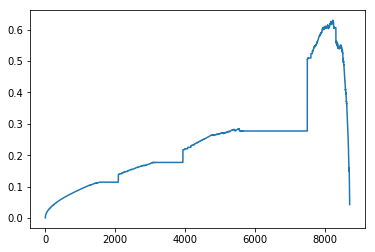

In [24]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [25]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks_ID,4100.973948
StdAmp_ID,2435.650426
StdAmpPos_ID,703.880668
MinAmp_ID,679.089226
MeanAmpNeg_ID,386.206140
NumPosPeaks_ID,355.663838
MeanAmpPos_ID,276.365501
MeanAmp_ID,268.422972
MeanAmpAll_AD,267.844061
MaxAmp_ID,200.891014


In [26]:
feature_imp = []
for model in clf:
    feature_imp.append(model.feature_importance(importance_type='gain'))

pd.DataFrame(feature_imp, columns=train.columns).T.sort_values(by=0, ascending=False)

,0,1,2,3
NumNegPeaks_ID,4755.614380,4300.275185,2311.684324,5036.321903
StdAmp_ID,2340.166789,3064.931008,1523.047903,2814.456004
StdAmpPos_ID,1114.265111,1217.957953,0.000000,483.299608
MinAmp_ID,890.460072,675.229632,519.978092,630.689110
MeanAmp_ID,515.838302,157.596818,146.516703,253.740067
NumPosPeaks_ID,449.773108,371.926268,64.242901,536.713077
MeanAmpNeg_ID,428.067775,139.463060,71.902102,905.391623
MeanAmpPos_ID,425.239510,282.395791,0.000000,397.826701
MeanAmpAll_AD,367.209279,259.244946,192.240398,252.681619
MaxAmp_ID,321.867980,192.832519,68.473700,220.389858


In [27]:
best_proba

0.26983888233217046

In [28]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


In [29]:
stdampall_ad = np.load('../features/stdampall_ad_test.npy')
stdampq2_ad = np.load('../features/stdampq2_ad_test.npy')
stdampq3_ad = np.load('../features/stdampq3_ad_test.npy')
stdampq4_ad = np.load('../features/stdampq4_ad_test.npy')

meanampall_ad = np.load('../features/meanampall_ad_test.npy')
meanampq2_ad = np.load('../features/meanampq2_ad_test.npy')
meanampq3_ad = np.load('../features/meanampq3_ad_test.npy')
meanampq4_ad = np.load('../features/meanampq4_ad_test.npy')

meanamppos = np.load('../features/meanamppos_test.npy')
meanampneg = np.load('../features/meanampneg_test.npy')


In [30]:
numpeaks_id = np.load('../features/numpeaks_id_test.npy')
numpospeaks_id = np.load('../features/numpospeaks_id_test.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id_test.npy')

maxamp_id = np.load('../features/maxamp_id_test.npy')
minamp_id = np.load('../features/minamp_id_test.npy')
meanamp_id = np.load('../features/meanamp_id_test.npy')

meanamppos_id = np.load('../features/meanamppos_id_test.npy')
meanampneg_id = np.load('../features/meanampneg_id_test.npy')


In [31]:
stdamp_id_test = np.load('../features/stdamp_id_test.npy')
stdamppos_id_test = np.load('../features/stdamppos_id_test.npy')
stdampneg_id_test = np.load('../features/stdampneg_id_test.npy')

In [32]:
test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id[0:20000], 'NumPosPeaks_ID':numpospeaks_id[0:20000], 'NumNegPeaks_ID':numnegpeaks_id[0:20000],
                        'MaxAmp_ID':maxamp_id[0:20000], 'MinAmp_ID':minamp_id[0:20000], 'MeanAmp_ID':meanamp_id[0:20000],
                        'MeanAmpPos_ID':meanamppos_id[0:20000], 'MeanAmpNeg_ID':meanampneg_id[0:20000],
                        'StdAmp_ID':stdamp_id_test[0:20000], 'StdAmpPos_ID':stdamppos_id_test[0:20000],
                        'StdAmpNeg_ID':stdampneg_id_test[0:20000], 
                        })

In [33]:
test = pd.concat([meta_test, test_features], axis=1)

In [34]:
test_id = test['signal_id'].values
del test['signal_id']

In [35]:
preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

In [36]:
submission = pd.DataFrame({'signal_id':test_id,'target':(preds>best_proba).astype(int)})

In [37]:
submission.to_csv('../output/submission_9.csv', index=False)

In [36]:
np.max(preds)

0.5244148699418933

In [37]:
pd.Series((preds>best_proba).astype(int)).value_counts()

0    20117
1      220
dtype: int64